#### Import essential libraries/dependencies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import math
import os
import scipy
import sklearn
import statsmodels
import tensorflow
import xgboost
import datetime

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

#Time series models
from statsmodels.tsa.api import adfuller, ETSModel, ARIMA, ExponentialSmoothing, Holt, seasonal_decompose, SimpleExpSmoothing, VAR, VARMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model

#Recurrent Neural network models 
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings('ignore')


#### Import dataset/file directly from Kaggle.

In [4]:
#import necessary libraries 
import kagglehub
import os
import shutil

#step1: get the current working directory
current_dir = os.getcwd()
print("Current dir:", current_dir)

# Step 2: Download dataset (returns temp path where it's stored)
dataset_path = kagglehub.dataset_download("arashnic/time-series-forecasting-with-yahoo-stock-price")
print("Downloaded dataset path:", dataset_path)

# Step 3: Move file(s) to current working directory
source_file = os.path.join(dataset_path, "yahoo_stock.csv")
destination_file = os.path.join(current_dir, "yahoo_stock_data.csv")

# Copy to current working directory. shutil is for copying and archiving files. 
shutil.copy(source_file, destination_file)
print("File copied to the current working directory.")


Current dir: d:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Yahoo stock price (Refer this)\notebooks
Downloaded dataset path: C:\Users\Ramya\.cache\kagglehub\datasets\arashnic\time-series-forecasting-with-yahoo-stock-price\versions\3
File copied to the current working directory.


#### Read and format data 

In [5]:
#Read the data
data = pd.read_csv(r"D:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Yahoo stock price (Refer this)\notebooks\yahoo_stock_data.csv")

#drop last column
data = data.iloc[:,:-1]

#Format date column
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

#### Data visualization 

Trends in Closing price


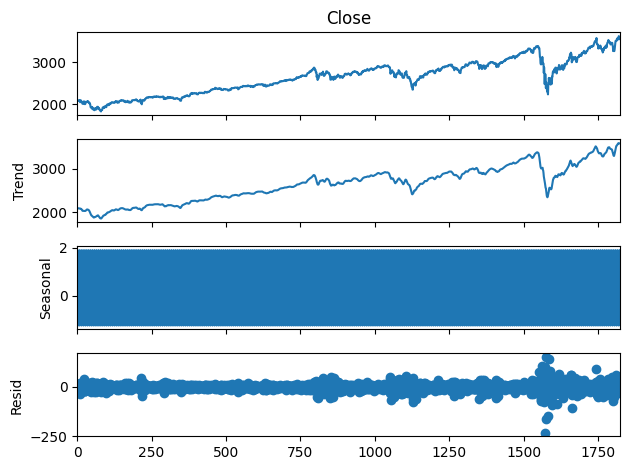

<Figure size 600x300 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [31]:
sd = seasonal_decompose(data['Close'], model='additive', period=7)
print("Trends in Closing price")
sd.plot()
mp.figure(figsize=(6,3))
mp.show()


#define the directory and save the plot
directory = "D:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Yahoo stock price (Refer this)\plots"
filename = "Seasonal_decomposition_plot_closing_price.png"
filepath = os.path.join(directory, filename)
mp.savefig(filepath)

Trends in Volume


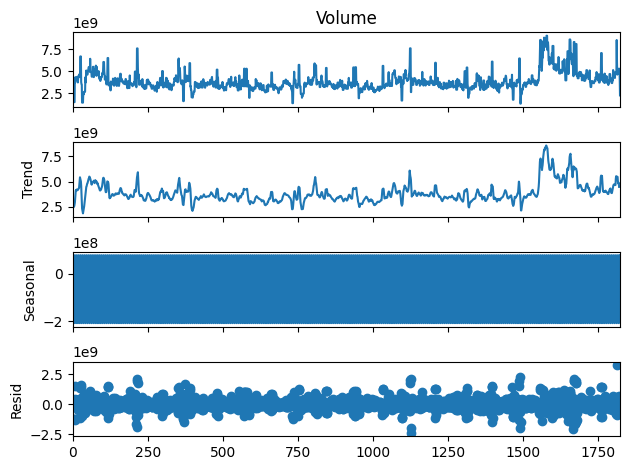

<Figure size 600x300 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [32]:
sd = seasonal_decompose(data['Volume'], model='additive', period=7)
print("Trends in Volume")
sd.plot()
mp.figure(figsize=(6,3))
mp.show()


#define the directory and save the plot
directory = "D:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Yahoo stock price (Refer this)\plots"
filename = "Seasonal_decomposition_plot_volume.png"
filepath = os.path.join(directory, filename)
mp.savefig(filepath)

#### Stationarity check

In [33]:
def stationarity_check(data, col):
    result = adfuller(data[col])
    if result[1]<0.05:
        print(f'Feature {col} is stationary')
    else:
        print(f'Feature {col} is not stationary')
    return

stationarity_check(data, col='Close')    #stationarity check for Closing price
stationarity_check(data, col='Volume')    #stationarity check for Volume

Feature Close is not stationary
Feature Volume is stationary


#### Check Autocorrelation

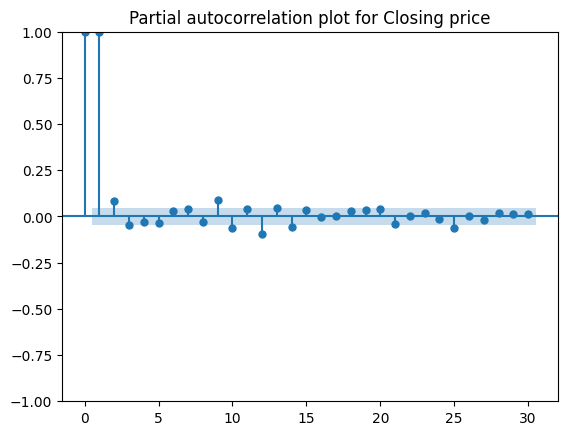

<Figure size 640x480 with 0 Axes>

In [34]:
plot_pacf(data['Close'], lags=30, title='Partial autocorrelation plot for Closing price')
mp.show()


#define the directory and save the plot
directory = "D:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Yahoo stock price (Refer this)\plots"
filename = "pacf_plot_closing_price.png"
filepath = os.path.join(directory, filename)
mp.savefig(filepath)

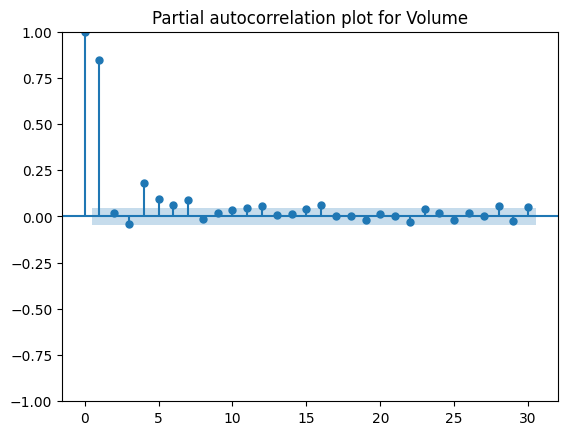

<Figure size 640x480 with 0 Axes>

In [35]:
plot_pacf(data['Volume'], lags=30, title='Partial autocorrelation plot for Volume')
mp.show()


#define the directory and save the plot
directory = "D:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Yahoo stock price (Refer this)\plots"
filename = "pacf_plot_volume.png"
filepath = os.path.join(directory, filename)
mp.savefig(filepath)

#### TimeSeries Forecasting 

In [6]:
timeseries_data = data.copy()    #for time series and neural network models 

In [7]:
#convert data into stationary
timeseries_data['Close'] = timeseries_data['Close'].pct_change(periods=1).mul(100)
timeseries_data = timeseries_data.iloc[1:,:]

In [ ]:
#set Date as index for time series data
timeseries_data.set_index('Date',inplace=True)
timeseries_data = timeseries_data.asfreq('D') 

#define training and test size
training_size = int(len(timeseries_data)*0.70)

#split the data into train, test basis size
train_data = timeseries_data[:training_size]
test_data = timeseries_data[training_size:]

#define the exogeneous variables
train_data_exog= train_data.drop(columns='Close')
train_data_exog = train_data_exog.loc[train_data_exog.index]

test_data_exog = test_data.drop(columns='Close')
test_data_exog = test_data_exog.loc[test_data_exog.index]

ARIMA model results:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1276
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -856.535
Date:                Tue, 06 May 2025   AIC                           1733.069
Time:                        19:58:39   BIC                           1784.584
Sample:                    11-24-2015   HQIC                          1752.416
                         - 05-22-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0864   1.62e-09   5.34e+07      0.000       0.086       0.086
High           0.0267   5.71e-06   4674.877      0.000       0.027       0.027
Low            0.0244   5.69e-0

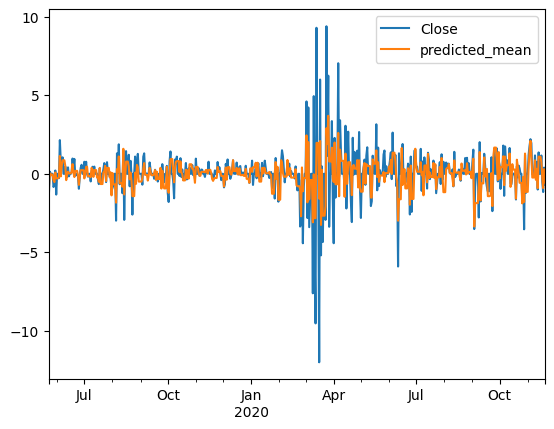

In [40]:
#ARIMA model to predict "Close" --closing price
arima_mod = ARIMA(endog=train_data['Close'], order=(4,0,0), exog=train_data_exog)
arima_mod = arima_mod.fit()

print("ARIMA model results:")
print(arima_mod.summary())
print()

#define index
start=len(train_data)
end=len(train_data)+len(test_data)-1

#make predictions
arima_predictions = arima_mod.predict(start=start, end=end, exog=test_data_exog)

directory_to_save_predictions = "D:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Yahoo stock price (Refer this)\outputs"
filename = "closing_price_predictions.csv"
filepath = os.path.join(directory_to_save_predictions, filename)
arima_predictions.to_csv(filepath, index=False)

#check error metric
arima_mae = round(mean_absolute_error(test_data['Close'], arima_predictions),2)
arima_rmse = round(math.sqrt(mean_squared_error(test_data['Close'], arima_predictions)),2)
arima_mape = round(mean_absolute_percentage_error(test_data['Close'], arima_predictions),2)*100

print(f'MAE:{arima_mae}, RMSE:{arima_rmse}, predictions are off by {arima_mape}%')

#compare actual vs predicted
actual_vs_predicted = pd.concat([test_data['Close'], arima_predictions], axis=1)

#visualization of actual vs predicted
actual_vs_predicted.plot()

#define the directory and save the plot
directory = "D:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Yahoo stock price (Refer this)\plots"
filename = "actual_vs_predicted_closing_price.png"
filepath = os.path.join(directory, filename)
mp.savefig(filepath)

ARIMA model results:
                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                 1276
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -27286.164
Date:                Tue, 06 May 2025   AIC                          54590.328
Time:                        19:58:39   BIC                          54636.692
Sample:                    11-24-2015   HQIC                         54607.740
                         - 05-22-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.956e+09      2.156    2.3e+09      0.000    4.96e+09    4.96e+09
High        2.036e+07   5334.443   3817.105      0.000    2.04e+07    2.04e+07
Low        -2.416e+07   5272.87

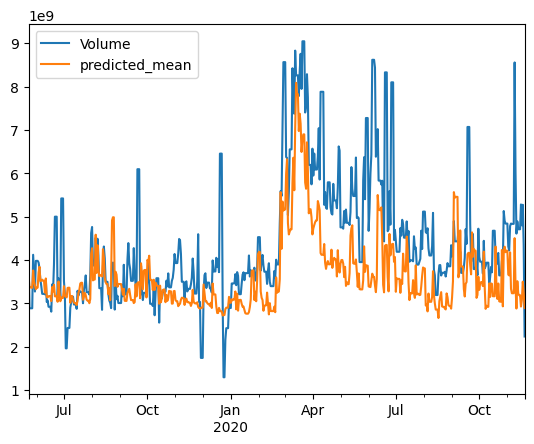

In [41]:
#ARIMA model to predict "Volume" -- stock quantity

#define the exogeneous variables
train_data_exog_vol= train_data.drop(columns='Volume')
test_data_exog_vol = test_data.drop(columns='Volume')

#build the model
arima_mod_vol = ARIMA(endog=train_data['Volume'], order=(3,0,0), exog=train_data_exog_vol)
arima_mod_vol = arima_mod_vol.fit()

print("ARIMA model results:")
print(arima_mod_vol.summary())
print()

#define index
start=len(train_data)
end=len(train_data)+len(test_data)-1

#make predictions
arima_vol_predictions = arima_mod_vol.predict(start=start, end=end, exog=test_data_exog_vol)

directory_to_save_predictions = "D:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Yahoo stock price (Refer this)\outputs"
filename = "volume_predictions.csv"
filepath = os.path.join(directory_to_save_predictions, filename)
arima_predictions.to_csv(filepath, index=False)

#check error metric
arima_vol_mae = round(mean_absolute_error(test_data['Volume'], arima_vol_predictions),2)
arima_vol_rmse = round(math.sqrt(mean_squared_error(test_data['Volume'], arima_vol_predictions)),2)
arima_vol_mape = round(mean_absolute_percentage_error(test_data['Volume'], arima_predictions),2)*100

print(f'MAE:{arima_vol_mae}, RMSE:{arima_vol_rmse} and predictions are off by {arima_vol_mape}')

#compare actual vs predicted
actual_vs_predicted = pd.concat([test_data['Volume'], arima_vol_predictions], axis=1)

#visualization of actual vs predicted
actual_vs_predicted.plot()


#define the directory and save the plot
directory = "D:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Yahoo stock price (Refer this)\plots"
filename = "actual_vs_predicted_volume.png"
filepath = os.path.join(directory, filename)
mp.savefig(filepath)

##### ARCH and GARCH models

Iteration:      1,   Func. Count:      8,   Neg. LLF: 7961.855724503055
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2344.4864429980544
Iteration:      3,   Func. Count:     29,   Neg. LLF: 2862.1806183190133
Iteration:      4,   Func. Count:     37,   Neg. LLF: 1405.592009143675
Iteration:      5,   Func. Count:     45,   Neg. LLF: 1249.957914126147
Iteration:      6,   Func. Count:     53,   Neg. LLF: 1314.7330505764744
Iteration:      7,   Func. Count:     62,   Neg. LLF: 1227.7561173517731
Iteration:      8,   Func. Count:     71,   Neg. LLF: 1209.9179223697697
Iteration:      9,   Func. Count:     80,   Neg. LLF: 1208.5460374909412
Iteration:     10,   Func. Count:     87,   Neg. LLF: 1208.5398758251472
Iteration:     11,   Func. Count:     94,   Neg. LLF: 1208.5398598771299
Iteration:     12,   Func. Count:    101,   Neg. LLF: 1208.5398594052854
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1208.5398594052854
            Iterat

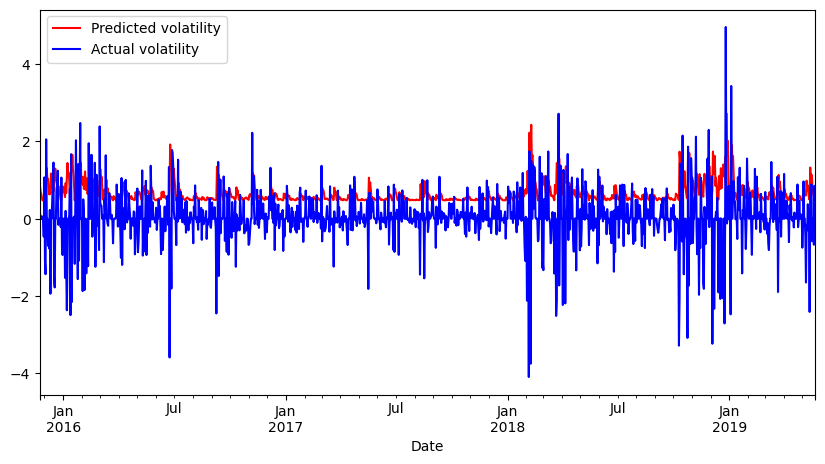

<Figure size 640x480 with 0 Axes>

In [42]:
#ARCH model
arch_mod = arch_model(train_data['Close'], vol='ARCH', p=4)
arch_fitted_mod = arch_mod.fit()
print("ARCH model results")
print(arch_fitted_mod.summary())

# Forecast ARCH
garch_forecast = arch_fitted_mod.forecast(start=start, horizon=len(test_data), reindex=False)

#to plot the volatility
arch_fitted_mod.conditional_volatility.plot(figsize=(10,5), color = 'red')
train_data['Close'].plot(figsize=(10, 5), color='blue')
mp.legend(['Predicted volatility', 'Actual volatility'])
mp.show()


#define the directory and save the plot
directory = "D:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Yahoo stock price (Refer this)\plots"
filename = "ARCH_volatility.png"
filepath = os.path.join(directory, filename)
mp.savefig(filepath)

Iteration:      1,   Func. Count:     10,   Neg. LLF: 16345.196489028975
Iteration:      2,   Func. Count:     23,   Neg. LLF: 2746526.5605350053
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1347.0275236194148
Iteration:      4,   Func. Count:     43,   Neg. LLF: 2111.368769869603
Iteration:      5,   Func. Count:     54,   Neg. LLF: 1357.141914857576
Iteration:      6,   Func. Count:     64,   Neg. LLF: 1240.156949671542
Iteration:      7,   Func. Count:     74,   Neg. LLF: 2219.2777444830745
Iteration:      8,   Func. Count:     84,   Neg. LLF: 1140.8158545900296
Iteration:      9,   Func. Count:     94,   Neg. LLF: 1175.3401266475228
Iteration:     10,   Func. Count:    104,   Neg. LLF: 1132.2753707444208
Iteration:     11,   Func. Count:    114,   Neg. LLF: 1126.1653767482785
Iteration:     12,   Func. Count:    123,   Neg. LLF: 1150.0297042394895
Iteration:     13,   Func. Count:    134,   Neg. LLF: 1126.0667589860668
Iteration:     14,   Func. Count:    144,   Neg. LLF: 

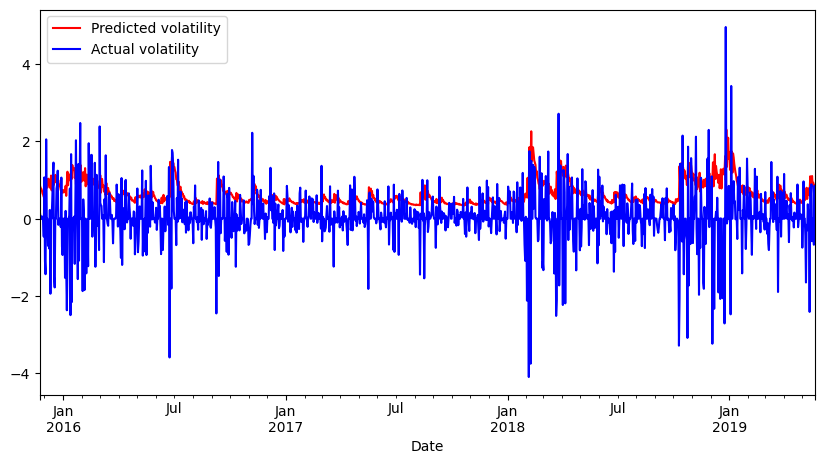

<Figure size 640x480 with 0 Axes>

In [43]:
#ARCH model
garch_mod = arch_model(train_data['Close'], vol='GARCH', p=4, q=2)
garch_fitted_mod = garch_mod.fit()
print("GARCH model results")
print(garch_fitted_mod.summary())

# Forecast ARCH
garch_forecast = garch_fitted_mod.forecast(start=start, horizon=len(test_data), reindex=False)

#to plot the volatility
garch_fitted_mod.conditional_volatility.plot(figsize=(10,5), color = 'red')
train_data['Close'].plot(figsize=(10, 5), color='blue')
mp.legend(['Predicted volatility', 'Actual volatility'])
mp.show()

#define the directory and save the plot
directory = "D:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Yahoo stock price (Refer this)\plots"
filename = "GARCH_volatility.png"
filepath = os.path.join(directory, filename)
mp.savefig(filepath)